In [46]:
#Movie recommendation using MovieLens dataset

!pip install pandas matplotlib seaborn numpy scikit-learn

In [47]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip -d movielens_data

--2025-09-04 15:11:57--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip [following]
--2025-09-04 15:11:57--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.3’

ml-latest-small.zip 100%[===================>] 955.28K  3.30MB/s    in 0.3s    

2025-09-04 15:11:58 (3.30 MB/s) - ‘ml-latest-small.zip.3’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace movielens_data/ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [49]:
movies = pd.read_csv('movielens_data/ml-latest-small/movies.csv')
ratings = pd.read_csv('movielens_data/ml-latest-small/ratings.csv')
tags = pd.read_csv('movielens_data/ml-latest-small/tags.csv')
links = pd.read_csv('movielens_data/ml-latest-small/links.csv')

In [50]:
print("Movies dataset:")
print(movies.head())
print(f"\nMovies shape: {movies.shape}")

print("\nRatings dataset:")
print(ratings.head())
print(f"\nRatings shape: {ratings.shape}")

print("\nTags dataset:")
print(tags.head())
print(f"\nTags shape: {tags.shape}")

print("\nLinks dataset:")
print(links.head())
print(f"\nLinks shape: {links.shape}")

Movies dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Movies shape: (9742, 3)

Ratings dataset:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Ratings shape: (100836, 4)

Tags dataset:
   userId  movieId              tag   timestamp
0       2    60756         

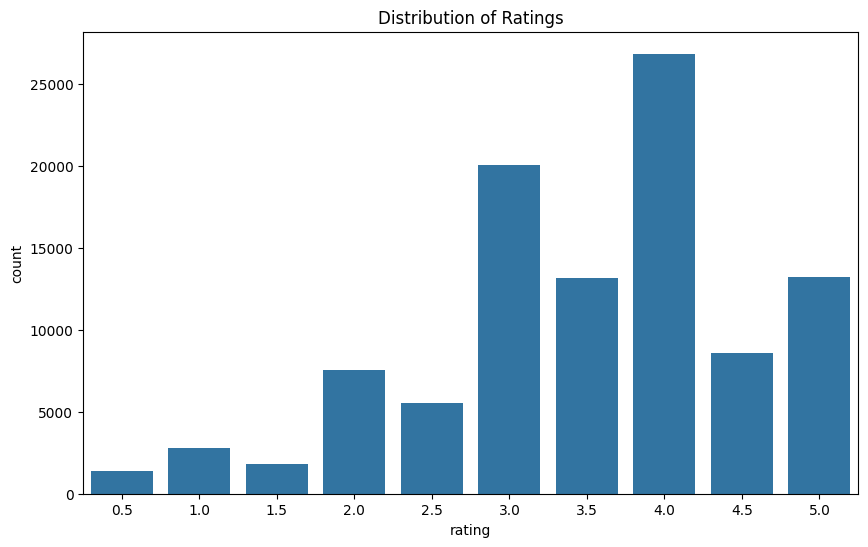

In [51]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

In [52]:
movie_ratings = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
movie_ratings = movie_ratings.merge(movies, on='movieId')

In [53]:
top_movies = movie_ratings[movie_ratings['count'] >= 50].nlargest(10, 'mean')
print("Top 10 highest rated movies:")
print(top_movies[['title', 'mean', 'count']])

Top 10 highest rated movies:
                                                  title      mean  count
277                    Shawshank Redemption, The (1994)  4.429022    317
659                               Godfather, The (1972)  4.289062    192
2224                                  Fight Club (1999)  4.272936    218
974                               Cool Hand Luke (1967)  4.271930     57
602   Dr. Strangelove or: How I Learned to Stop Worr...  4.268041     97
686                                  Rear Window (1954)  4.261905     84
921                      Godfather: Part II, The (1974)  4.259690    129
6298                               Departed, The (2006)  4.252336    107
913                                   Goodfellas (1990)  4.250000    126
694                                   Casablanca (1942)  4.240000    100


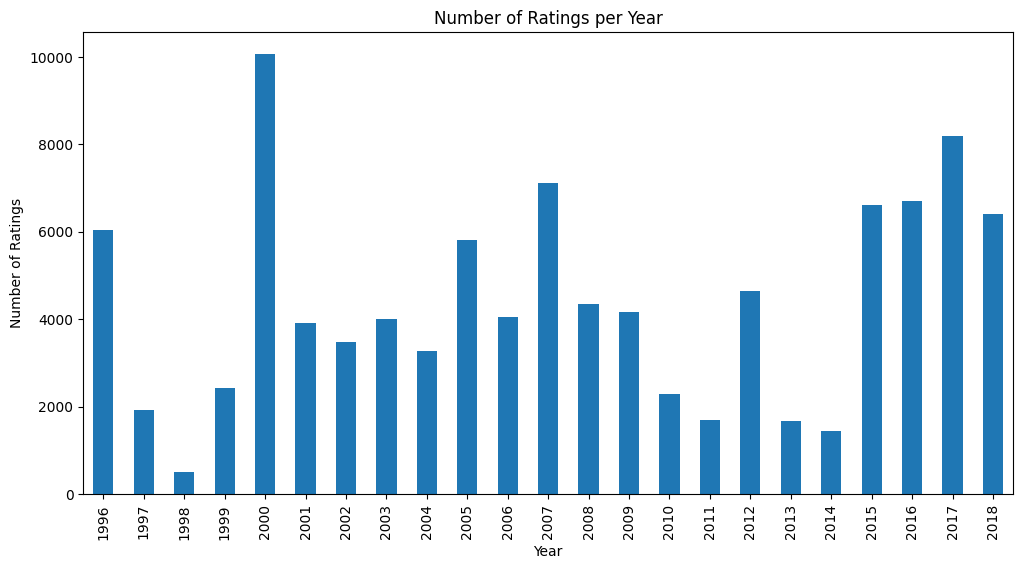

In [54]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year

plt.figure(figsize=(12, 6))
ratings['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

In [55]:
print(ratings.head())
ratings = ratings.drop('timestamp', axis=1)

# Create user-item matrix
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Fill missing ratings with 0 (for similarity calculations)
user_movie_matrix_filled = user_movie_matrix.fillna(0)

print(user_movie_matrix_filled.head())

   userId  movieId  rating           timestamp  year
0       1        1     4.0 2000-07-30 18:45:03  2000
1       1        3     4.0 2000-07-30 18:20:47  2000
2       1        6     4.0 2000-07-30 18:37:04  2000
3       1       47     5.0 2000-07-30 19:03:35  2000
4       1       50     5.0 2000-07-30 18:48:51  2000
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                

In [56]:
#Cosine Similarity for user
user_similarity = cosine_similarity(user_movie_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

print(user_similarity_df.head())

userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
2       0.027283  1.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
3       0.059720  0.000000  1.000000  0.002251  0.005020  0.003936  0.000000   
4       0.194395  0.003726  0.002251  1.000000  0.128659  0.088491  0.115120   
5       0.129080  0.016614  0.005020  0.128659  1.000000  0.300349  0.108342   

userId       8         9         10   ...       601       602       603  \
userId                                ...                                 
1       0.136968  0.064263  0.016875  ...  0.080554  0.164455  0.221486   
2       0.027257  0.000000  0.067445  ...  0.202671  0.016866  0.011997   
3       0.004941  0.000000  0.000000  ...  0.005048  0.004892  0.024992   
4       0.062969  0.011361  0.031163  ...  0.085938  0.128273  0

In [57]:
#Cosine Similarity for item
item_similarity = cosine_similarity(user_movie_matrix_filled.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

print(item_similarity_df.head())

movieId    1         2         3         4         5         6         7       \
movieId                                                                         
1        1.000000  0.410562  0.296917  0.035573  0.308762  0.376316  0.277491   
2        0.410562  1.000000  0.282438  0.106415  0.287795  0.297009  0.228576   
3        0.296917  0.282438  1.000000  0.092406  0.417802  0.284257  0.402831   
4        0.035573  0.106415  0.092406  1.000000  0.188376  0.089685  0.275035   
5        0.308762  0.287795  0.417802  0.188376  1.000000  0.298969  0.474002   

movieId    8         9         10      ...  193565  193567  193571  193573  \
movieId                                ...                                   
1        0.131629  0.232586  0.395573  ...     0.0     0.0     0.0     0.0   
2        0.172498  0.044835  0.417693  ...     0.0     0.0     0.0     0.0   
3        0.313434  0.304840  0.242954  ...     0.0     0.0     0.0     0.0   
4        0.158022  0.000000  0.095598  ...

In [60]:
def recommend_movies_user_based(user_id, top_n=5):
    # Get similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)

    # Weighted ratings
    weighted_ratings = user_movie_matrix_filled.T.dot(similar_users) / similar_users.sum()

    # Exclude movies already rated by the user
    already_rated = user_movie_matrix_filled.loc[user_id]
    recommendations = weighted_ratings[already_rated.isna()].sort_values(ascending=False).head(top_n)

    recommended_movies = movies[movies['movieId'].isin(recommendations.index)]
    return recommended_movies[['movieId', 'title']]

print(recommend_movies_user_based(user_id=1, top_n=1))


Empty DataFrame
Columns: [movieId, title]
Index: []


In [61]:
def recommend_movies_item_based(movie_id, top_n=5):
    similar_movies = item_similarity_df[movie_id].sort_values(ascending=False)
    similar_movies = similar_movies.drop(movie_id).head(top_n)

    recommended_movies = movies[movies['movieId'].isin(similar_movies.index)]
    return recommended_movies[['movieId', 'title']]

print(recommend_movies_item_based(movie_id=1, top_n=5))


      movieId                                      title
224       260  Star Wars: Episode IV - A New Hope (1977)
314       356                        Forrest Gump (1994)
418       480                       Jurassic Park (1993)
615       780       Independence Day (a.k.a. ID4) (1996)
2355     3114                         Toy Story 2 (1999)
